# Nutrition Datas: Extracting trends from our customers

<div class="alert alert-block alert-info">
Now we are done with scrapping nutrition values, we want to build the actual nutrition profile: in order to do so, we first need to first extract the mass of each article, in order to assess the total sold mass.
</div>

In [1]:
from __future__ import print_function

%matplotlib inline
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from requests import get
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from matplotlib.ticker import MaxNLocator
import re
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle
import sys
sys.path.insert(1, './utilities/')
import weight_functions as wf 
from tabulate import tabulate

In [2]:
product_df = pd.read_csv('../data/dunnhumby_data/product.csv')
transaction_data_df = pd.read_csv('../data/dunnhumby_data/transaction_data.csv')


## Limiting our dataset

In [3]:
food_related_arr = np.array(['NUTRITION','GROCERY','PASTRY','MEAT-PCKGD','SEAFOOD-PCKGD','PRODUCE','DELI','MEAT','SALAD BAR','GRO BAKERY','FROZEN GROCERY','SPIRITS','RESTAURANT'])
#products related to food only
food_product_df = product_df.loc[(product_df['DEPARTMENT'].isin(food_related_arr))]
food_product_df = food_product_df[~food_product_df.COMMODITY_DESC.isin(['PAPER TOWELS','BATH TISSUES','LAUNDRY DETERGENTS','FD WRAPS/BAGS/TRSH BG']) ]

#transaction dataset related to food only
food_transaction_data = transaction_data_df.merge(food_product_df,how = 'inner',on = 'PRODUCT_ID')
food_transaction_data['dunn_name'] = food_transaction_data['COMMODITY_DESC'] + " " + food_transaction_data['SUB_COMMODITY_DESC']
food_transaction_data = food_transaction_data.drop(columns = ['COMMODITY_DESC','SUB_COMMODITY_DESC'])[['household_key','BASKET_ID','PRODUCT_ID','QUANTITY','CURR_SIZE_OF_PRODUCT','dunn_name']]

In [144]:
food_product_df[food_product_df.SUB_COMMODITY_DESC.str.contains('NON-CRBNTD DRNK')]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
168,32160,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,2.50 GA
304,35895,1208,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,33.8 OZ
390,39839,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,1 GA
1568,84208,1208,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,20 OZ
1972,100389,1208,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,.5 LTR
...,...,...,...,...,...,...,...
70111,9837404,103,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,144 OZ
71219,9993322,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,2416.9 OZ
72524,10256703,6231,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,5 GL
81320,13115723,103,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,20 OZ


<div class="alert alert-block alert-info">    
Ideally one want to have an idea of which items are consumed the most in terms of mass, unfortunately, the mass section presents a lot of different units which are not easily parsable.
</div>

In [4]:
#as we can see, there are a lot of different units
units = food_transaction_data.CURR_SIZE_OF_PRODUCT.unique()
index = np.random.choice(units.shape[0], 30, replace=False)  
units[index]

array(['15 LB', '1.5 LIT', '5.25 OUNCE', '3.13 OZ', '15.7 OZ', '6-2 OZ',
       ':  1.75 OZ', '1.2 LBS', '120 CT', '4.22 OZ', '13.2 OZ',
       '4/.64 OZ', '15.25 OZ', '12 STICKS', '12.1OZ', '40 LOADS',
       'R     1 OZ', '10 3/8 OZ', '1.40 OZ', '1.28 LB', 'B D  16 OZ',
       '3.65 OZ', '375ML', '3/6 OZ CAN', '10.4OZ', '@    24 OZ',
       '1/2 GAL', '24PK 12 OZ', '4.4 OZ.', '4.5OZ'], dtype=object)

## Extracting the weight

<div class="alert alert-block alert-info">
The goal consists in extracting the weights to numerical values using regexes. Unfortunately, all units cannot be taken into account.
</div>

In [5]:
bad_units = food_transaction_data[~food_transaction_data.CURR_SIZE_OF_PRODUCT.str.contains('^.*(?:LB|GA|DZ|OZ|OUNCE|PK|CT|LITER|LT|LTR|ML|QT|PT|PINT|QUART).*$|^\s?$',regex=True)].CURR_SIZE_OF_PRODUCT.unique()
print('List of units not treated by the regex: {}'.format(bad_units))

List of units not treated by the regex: ['60 LOAD' '40 LOAD' '10 INCH' 'LARGE' '1GL' '1 KIT' '34 LD' '4 INCH'
 '2 PACK' '80 USE' '40 LOADS' '60 LOADS' '6 USE' '3 PACK' '52 LD'
 '8-9 INCH' '60 GM' '7 IN' '60 LD' '3.5 INCH' '5.5 INCH' '1IN X 18IN'
 '1IN X 22IN' '5 PIECE' '5 INCH' '120 USE' '3X4 IN' '8 INCH' 'BIN' '9 IN'
 '90 LOAD' '4.5 INCH' '9 COUNT' '15 INCH' '7 INCH' '6.7 INCH' '1/2 BU BOX'
 '5/8 X 12IN' '3/8 X 10IN' '1/4 X 4 FT' '24 BUNCHES' '10 IN' '3 DOSE/LRG'
 '4/6 PACK' 'TALL' '9 INCH' '8-9 IN' '3/8 X 12IN' '3/8 X 8 IN'
 '1IN X 26IN' '2 PIECE' '1500 CU IN' '3/4 X 18IN' '28 GM' '52 LOAD'
 '6 COUNT' '3/8 INCH' '12 COUNT' 'MED' '3/4 X 6 FT' '3 POUND' '3/8 X 6 FT'
 'GL' '3-4 IN' '4-5IN' '10 COUNT' '100 GRAM' '1.5 LIT' '2 MM' 'REGULAR'
 '2 INCH' '26 LD' '14 INCH' '20 BAGS' '1 INCH LRG' '4 PACK' '750 CU IN'
 '12 STICKS' '1 INCH' '24 STRIPS' '45 GRAM' '3 PIECE' '3/4 IN MED'
 '5 INCHES' '70 LD' '37GRAMS' '3.0 LIT' '6 PC' '3 LIT' 'HD 20FT'
 '8IN X 14IN' '1IN X 24IN' '1 GL' '12 INCH' '22IN

<div class="alert alert-block alert-info">
Luckily, the vast majority of our food data gets treated.
</div>

In [9]:
food_trans_clean_df = food_transaction_data[food_transaction_data.CURR_SIZE_OF_PRODUCT.str.contains('^.*(?:LB|GA|DZ|OZ|OUNCE|PK|CT|LITER|LT|LTR|ML|QT|PT|PINT|QUART).*$|^\s?$',regex=True)].copy()
print('{} % of the data is treated'.format(food_trans_clean_df.shape[0] / food_transaction_data.shape[0] * 100))

99.86288554965542 % of the data is treated


<div class="alert alert-block alert-info">
The followings are the units we take into account for our data:
</div>

LB = pounds<br>
GA = gallons<br>
DZ = dozens (eggs)<br>
OZ,OUNCE = ounces<br>
PK = pack (0.33 liters)<br>
LITER LT = liters<br>
ML = milliliters<br>
PT = pint (0.473176473 liters)<br>

<div class="alert alert-block alert-info">
Once again, regexes are used (cf weight_functions.py) in order to parse the weight and convert it into kg. All the liquids were assumed to have water-like density. You can test the tool in the following cell.
</div>

In [10]:
UNITS = ['LB','GA','DZ','OZ','OUNCE','PK','CT','LITER','LT','ML','QT','PT']

test_weights_volumes = ['422 Lt','(600) 4OUNCE','5.323 OZ','there is 3 pint','2 CT']
def f(x):
    tested = test_weights_volumes[x]
    print('Tested expression: %s .Equivalent weight computed: %.2f kg' % (tested,wf.get_weight(tested)))
interact(f, x=widgets.IntSlider(min=0, max=len(test_weights_volumes) - 1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [11]:
food_trans_clean_df['SINGLE_WEIGHT']  = food_trans_clean_df.CURR_SIZE_OF_PRODUCT.apply(wf.get_weight).values

<div class="alert alert-block alert-info">
The same method is used to extract the weight of the articles.
Unfortunately, the data whose metric is either CT,QT (quantity) or simply not present cannot easily be computed as this would require items specific weights. (a capsicon does not have the same weight as a pumpkin) 

We thus ask the user to estimate the weight of each item, thanks to the function start_create_single_weights.
</div>

In [12]:
#The three dataframes were user input created
single_weights_ct_df = pd.DataFrame.from_dict(wf.start_create_single_weights('CT',food_trans_clean_df),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})
single_weights_qt_df = pd.DataFrame.from_dict(wf.start_create_single_weights('QT',food_trans_clean_df),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})
single_weights_space_df = pd.DataFrame.from_dict(wf.start_create_single_weights('space',food_trans_clean_df),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})

Successful read.
Successful read.
Successful read.


In [13]:
food_trans_clean_df = food_trans_clean_df.join(single_weights_ct_df,how = 'left',rsuffix ='_r')
food_trans_clean_df.SINGLE_WEIGHT.fillna(food_trans_clean_df.SINGLE_WEIGHT_r,inplace = True)
food_trans_clean_df.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

food_trans_clean_df = food_trans_clean_df.join(single_weights_qt_df,how = 'left',rsuffix ='_r')
food_trans_clean_df.SINGLE_WEIGHT.fillna(food_trans_clean_df.SINGLE_WEIGHT_r,inplace = True)
food_trans_clean_df.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

food_trans_clean_df = food_trans_clean_df.join(single_weights_space_df,how = 'left',rsuffix ='_r')
food_trans_clean_df.SINGLE_WEIGHT.fillna(food_trans_clean_df.SINGLE_WEIGHT_r,inplace = True)
food_trans_clean_df.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

In [15]:
food_trans_clean_df['TOT_WEIGHT'] = food_trans_clean_df.SINGLE_WEIGHT * food_trans_clean_df.QUANTITY
food_trans_clean_df.sort_values(by = 'TOT_WEIGHT',ascending = False,inplace = True)

<div class="alert alert-block alert-info">
We now have a dataframe which takes the weight of the items for each transaction.
</div>

In [18]:
food_trans_clean_df.head(5)

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,CURR_SIZE_OF_PRODUCT,dunn_name,SINGLE_WEIGHT,TOT_WEIGHT
329139,1566,35146090575,957951,22,22 LB,FRZN ICE ICE - CRUSHED/CUBED,9.979024,219.538528
1848213,1637,41573574844,874753,10,40 LB,HOUSEHOLD CLEANG NEEDS SALT/WATER CONDITIONERS,18.143680,181.436800
2022195,1023,32259671060,836878,10,40 LB,HOUSEHOLD CLEANG NEEDS SALT/WATER CONDITIONERS,18.143680,181.436800
22974,691,33421101510,1082185,9,40 LB,TROPICAL FRUIT BANANAS,18.143680,163.293120
2105435,57,31624497521,13038540,9,38 LB,ORGANICS FRUIT & VEGETABLES ORGANIC CITRUS,17.236496,155.128464


## Adding the nutrition

<div class="alert alert-block alert-info">
 The next step consists in adding the nutrition value for each of these transactions.
</div>

In [167]:
with open(r"../results/dunnhumb_articles_nutriments.pickle", "rb") as input_file:
    all_nutrition = pickle.load(input_file)
with open(r"../results/nutriments_units.pickle", "rb") as input_file:
    nutriment_units_df = pickle.load(input_file)
hh_demographic_df = pd.read_csv('../data/dunnhumby_data/hh_demographic.csv')

In [168]:
nutriments = all_nutrition.drop(all_nutrition.columns[np.arange(5)],axis = 1).columns.values

In [169]:
tot_weight_nut_df[tot_weight_nut_df.dunn_name.str.contains('LITER BTL CARB INCL')]

,dunn_name,TOT_WEIGHT,DEPARTMENT,dunn_ingredients,nut_name,nut_ingredients,cholesterol,energy,fatty acids total monounsaturated,fatty acids total polyunsaturated,...,tot_fiber,tot_protein,tot_sodium,tot_sugars,tot_total lipid,tot_vitamin a,tot_vitamin b-12,tot_vitamin b-6,tot_vitamin e,tot_vitamin k
2,SOFT DRINKS SFT DRNK 2 LITER BTL CARB INCL,107754.002557,GROCERY,"[soft, drink, liter, carb, incl]","Soft drink, NFS","[soft, drink, nf]",0.0,42.0,0.0,0.0,...,0.0,0.0,323262.007672,1.071075e+06,26938.500639,0.0,0.0,0.0,0.0,0.0
769,CANNED JUICES SFT DRNK 2 LITER BTL CARB INCL,64.000000,GROCERY,"[soft, drink, liter, carb, incl]","Soft drink, NFS","[soft, drink, nf]",0.0,42.0,0.0,0.0,...,0.0,0.0,192.000000,6.361600e+02,16.000000,0.0,0.0,0.0,0.0,0.0


In [170]:
#(1) we groupby the name of each article in order to extract trends from the most sold items in terms of sold mass
tot_weight_nut_df = food_trans_clean_df.groupby(['dunn_name']).agg({'TOT_WEIGHT':'sum'})\
                     .join(all_nutrition.set_index('dunn_name'),how = 'inner')\
                     .sort_values(by = 'TOT_WEIGHT',ascending = False)\
                     .reset_index()\
                     .copy()
#(2) we groupby the name of each article in terms of number of sells this time
tot_sells_nut_df = food_trans_clean_df.groupby(['dunn_name']).agg({'QUANTITY':'sum'})\
                     .join(all_nutrition.set_index('dunn_name'),how = 'inner')\
                     .sort_values(by = 'QUANTITY',ascending = False)\
                     .reset_index()\
                     .copy()

#(3) we groupby the household, in order to detect specific nutritional behavior
house_nut_df = food_trans_clean_df.groupby(['household_key','dunn_name'])\
                      .agg({'TOT_WEIGHT':'sum'})\
                      .reset_index()\
                      .join(all_nutrition.set_index('dunn_name'),on = 'dunn_name',how = 'inner')\
                      .sort_values(by = 'TOT_WEIGHT',ascending = False)\
                      .copy()

### Mass items nutriments

<div class="alert alert-block alert-info">
We analyze the items most bought in terms of mass: lets take a look at the most bought items
</div>

In [171]:
#tot_weight_nut_df[tot_weight_nut_df.dunn_name.str.contains('DRINK NON-CRBNTD DR')]

In [172]:
tot_weight_nut_df.head(6)[['dunn_name','TOT_WEIGHT','nut_name']]

,dunn_name,TOT_WEIGHT,nut_name
0,TROPICAL FRUIT BANANAS,568654.682640,"Banana, raw"
1,FLUID MILK PRODUCTS FLUID MILK WHITE ONLY,158279.390752,"Milk, whole"
2,SOFT DRINKS SFT DRNK 2 LITER BTL CARB INCL,107754.002557,"Soft drink, NFS"
3,ONIONS ONIONS SWEET (BULK&BAG),101229.260620,"Onions, mature, raw"
4,WATER - CARBONATED/FLVRD DRINK NON-CRBNTD DRNK...,55172.619526,Water chestnut
5,GRAPES GRAPES RED,46509.962904,"Grapes, raw, NS as to type"


In [173]:
# compute the mass (0.1kg as unit) of each nutriment for each article
for nut in nutriments:
    tot_nut = 'tot_' + nut
    tot_weight_nut_df[tot_nut] = tot_weight_nut_df.TOT_WEIGHT.multiply(tot_weight_nut_df[nut])

In [174]:
def plot_nutriments(nut_indx,df,ax = None,sub_title = None):
    if ax is None:
        fig,ax = plt.subplots(1,figsize = (20,5))
    nutriment = nutriments[nut_indx]
    #top4000[top4000.TOT_WEIGHT != 0].reset_index().head(4000).plot.bar(y = nutriment,ax = ax)
    #temp = top4000[top4000.TOT_WEIGHT != 0].reset_index().head(300)
    temp = df.sort_values(by = 'TOT_WEIGHT',ascending = False).reset_index().head(300)
    sns.barplot(x = temp.index,y = temp[nutriment],ax = ax)
    unit = nutriment_units_df[nutriment_units_df['name'] == nutriment].unit_name.values[0]
    title = nutriment
    ax.set_title(title)
    ax.set_ylabel('%s %s per 100 grams' % (nutriment,unit))
    ax.set_xlabel('items (sorted by most bought mass)')
    empty_string_labels = ['']*len(ax.get_xticklabels())
    ax.set_xticklabels(empty_string_labels)

In [175]:
plot_tot_nut = lambda indx: plot_nutriments(indx,tot_weight_nut_df)
interact(plot_tot_nut, indx=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='indx', max=14), Output()), _dom_classes=('widget-interac…

### Most relevant items per nutriments

In [176]:
def g(x):
    nutriment = nutriments[x]
    temp = tot_weight_nut_df.sort_values(by = 'tot_' + nutriment,ascending = False)[['TOT_WEIGHT','dunn_name','nut_name','tot_' + nutriment]].head(5)
    print(nutriment.upper() + ' TOP NUTRIMENTS')
    print(print(tabulate(temp, headers='keys', tablefmt='psql')))
interact(g, x=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=14), Output()), _dom_classes=('widget-interact',…

### Number items nutriments

<div class="alert alert-block alert-info">
We analyze the items most bought in terms of counts: lets take a look at the most bought items
</div>

In [177]:
tot_sells_nut_df.head(6)[['dunn_name','QUANTITY','nut_name']]

,dunn_name,QUANTITY,nut_name
0,FLUID MILK PRODUCTS FLUID MILK WHITE ONLY,91449,"Milk, whole"
1,YOGURT YOGURT NOT MULTI-PACKS,65544,Yogurt dressing
2,SOFT DRINKS SOFT DRINKS 12/18&15PK CAN CAR,54983,"Soft drink, NFS"
3,SOFT DRINKS SFT DRNK 2 LITER BTL CARB INCL,54400,"Soft drink, NFS"
4,CHEESE SHREDDED CHEESE,35245,"Cheese, NFS"
5,BAKED BREAD/BUNS/ROLLS MAINSTREAM WHITE BREAD,34661,"Bread, white"


### Demographic nutriments

In [178]:
house_nut_df[nutriments] = house_nut_df[nutriments].multiply(house_nut_df.TOT_WEIGHT,axis = 0)# / 10    
house_nut_df = house_nut_df.drop(columns = ['dunn_name','dunn_ingredients','nut_name','nut_ingredients'])\
                                .groupby('household_key')\
                                .agg('sum')

#we average on the total amount of food consumed
house_nut_df[nutriments] = house_nut_df[nutriments].div(house_nut_df.TOT_WEIGHT,axis = 0)

In [179]:
house_nut_df = house_nut_df.join(hh_demographic_df.set_index('household_key'),how = 'inner')

house_nut_df[~house_nut_df.INCOME_DESC.str.contains('^[0-9]{2,3}-[0-9]{2,3}K$|Under 15K|250K+',regex = True)]

,TOT_WEIGHT,cholesterol,energy,fatty acids total monounsaturated,fatty acids total polyunsaturated,fatty acids total saturated,fiber,protein,sodium,sugars,...,vitamin b-6,vitamin e,vitamin k,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
household_key,,,,,,,,,,,,,,,,,,,,,


In [180]:
lower_numb = house_nut_df[house_nut_df.INCOME_DESC.str.contains('Under 15K')].shape[0]
higher_numb = house_nut_df[house_nut_df.INCOME_DESC.str.contains('250K+')].shape[0]
tot_num = house_nut_df.shape[0]
print('Poor represent %.2f of the dataset.' % (lower_numb / tot_num))
print('Wealhty represent %.2f of the dataset.' % (higher_numb / tot_num))

Poor represent 0.08 of the dataset.
Wealhty represent 0.01 of the dataset.


In [181]:
house_nut_df[['low_lim','high_lim']] = house_nut_df.INCOME_DESC.str.extract(r'^(\d{2,3})-(\d{2,3})K$')
house_nut_df.dropna(inplace = True)
house_nut_df[['low_lim','high_lim']] = house_nut_df[['low_lim','high_lim']].astype(int)
house_nut_df['av_income'] = (house_nut_df.low_lim + house_nut_df.high_lim).div(2)
house_nut_df.sort_values('av_income',inplace = True)
med = house_nut_df.av_income.median()
poors_df = house_nut_df[house_nut_df.av_income < med]
wealthy_df = house_nut_df[house_nut_df.av_income >= med]

In [182]:
poors_df.shape[0]

323

In [183]:
wealthy_df.shape[0]

406

In [184]:
def plot2nut(nut_indx,df1,df2):
    fig, ax = plt.subplots(1,figsize = (20,5))
    nutriment = nutriments[nut_indx]
    sns.distplot(poors_df[nutriment],norm_hist = True,ax = ax,label = 'poor')
    sns.distplot(wealthy_df[nutriment],norm_hist = True,ax = ax,label = 'wealthy')
    ax.set_title(nutriment)
    ax.legend()
    unit = nutriment_units_df[nutriment_units_df['name'] == nutriment].unit_name.values[0]
    ax.set_xlabel(unit + ' of ' + nutriment + ' /100g. of food')
    ax.set_ylabel('proportion of people')
    ttest = stats.ttest_ind(poors_df[nutriment], wealthy_df[nutriment], equal_var = False,)
    print('Pvalue of different means: {}'.format(ttest[1]))
    
plot_tot_nut = lambda indx: plot2nut(indx,poors_df,wealthy_df)
interact(plot_tot_nut, indx=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='indx', max=14), Output()), _dom_classes=('widget-interac…

#### Average nutriments consumption

Correlations between the average nutritional intake of each household


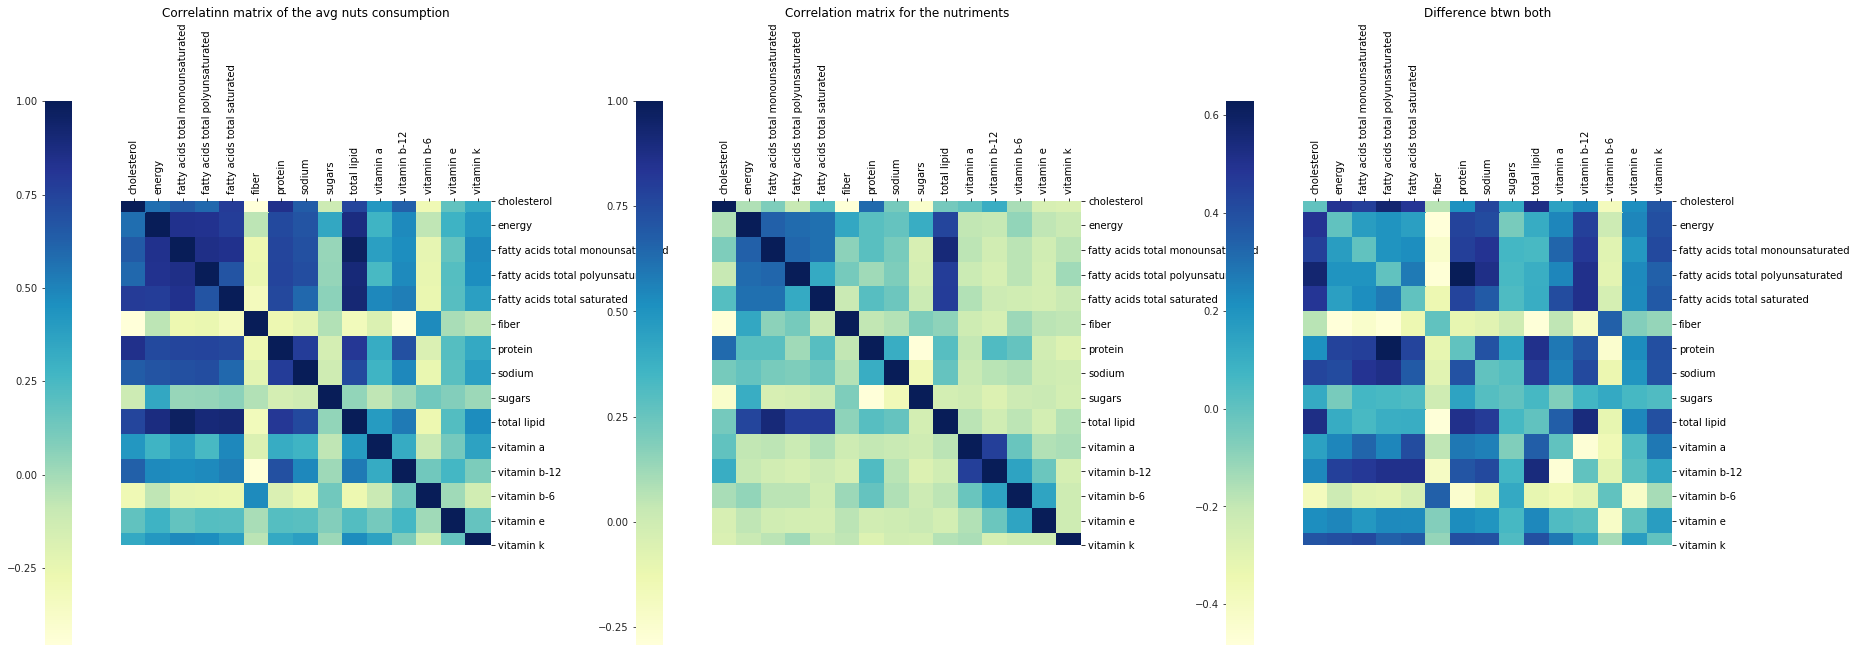

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [185]:
def plot_corr_mat(corrmat,title,ax):
    plt.figure()
    with sns.axes_style("white"):
        sns.heatmap(corrmat,\
                          cbar_kws = dict(use_gridspec=False,location="left"), \
                          xticklabels=True,yticklabels=True,\
                          #mask=mask,\
                          cmap="YlGnBu",square=True,\
                          ax = ax)
        ax.xaxis.set_ticks_position('top')
        ax.yaxis.set_ticks_position('right')
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        ax.set_yticklabels(ax.get_xticklabels(),rotation=0)
        ax.set_title(title)

corrmat_hseholds = house_nut_df[nutriments].corr()
corrmat_food = all_nutrition[nutriments].corr()
fig,axes = plt.subplots(1,3,figsize = (30,10))
plot_corr_mat(corrmat_hseholds,'Correlatinn matrix of the avg nuts consumption',axes[0])
plot_corr_mat(corrmat_food,'Correlation matrix for the nutriments',axes[1])
plot_corr_mat(corrmat_hseholds - corrmat_food,'Difference btwn both',axes[2])
print('Correlations between the average nutritional intake of each household')

We see that the sodium tends to be more consumed in association with sugar, sugars with vitb12.

In [186]:
from nltk.corpus import wordnet as wn
food = wn.synset('food.n.02')
FOOD_WORDS = list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()])) + ['drink']